In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path


import matplotlib.pyplot as plt
import matplotlib

import theano
import theano.tensor as tt
import pymc3 as pm
theano.config.optimizer="fast_run"

In [2]:
path.append("../src")
import Bernstein
import Population
import Cases

In [3]:
#Bernstein.Bernstein(4,16).eval()
with open("../Data/Cases/SurvStat_RKI/lks_210117.pickle","br") as f:
    cases = Cases.ParseSurvStatDay_BL(pickle.load(f))

    

In [4]:
pop = Population.ImportPopulation()

weeks = range(1,76)
wpop = Population.WeeklyPopulation(pop,weeks)

{0: '31.12.2019', 53: '31.12.2020', 105: '31.12.2021', 157: '31.12.2022'}


In [5]:
print(wpop.shape,"\n",wpop.coords)
print(wpop.sel(week=10,age=80).sum("BL"))

print(cases.coords)

(75, 16, 2, 101) 
 Coordinates:
  * BL       (BL) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * age      (age) int8 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * sex      (sex) <U6 'male' 'female'
  * week     (week) int64 1 2 3 4 5 6 7 8 9 10 ... 66 67 68 69 70 71 72 73 74 75
<xarray.DataArray (sex: 2)>
array([348943.39622642, 464566.03773585])
Coordinates:
    age      int8 80
  * sex      (sex) <U6 'male' 'female'
    week     int64 10
Coordinates:
  * category  (category) <U30 'lab and clinical met' ... 'lab met, clinical undetermined'
  * BL        (BL) int8 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * sex       (sex) <U7 'male' 'female' 'unknown'
  * age       (age) int8 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79 80
  * week      (week) int16 0 1 2 3 4 5 6 7 8 ... 100 101 102 103 104 105 106 107


In [6]:
age_cases10y,age_cases5y = Cases.RKI_Altersverteilung()
age_cases5y.coords

2020-11-17 00:00:00 weekly rows Altersverteilung_201117.csv
2020-11-10 00:00:00 weekly rows Altersverteilung_201110.csv


Coordinates:
  * age          (age) int64 90 85 80 75 70 65 60 55 ... 35 30 25 20 15 10 5 0
  * week         (week) int64 10 11 12 13 14 15 16 17 ... 49 50 51 52 53 54 55
  * publication  (publication) datetime64[ns] 2021-01-19 ... 2020-12-01

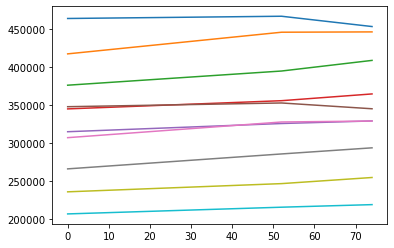

In [7]:
plt.plot(wpop.sel(sex="female",age=range(80,85)).sum("BL"))
plt.plot(wpop.sel(sex="male",age=range(80,85)).sum("BL"))

2020-11-17 00:00:00 weekly rows Altersverteilung_201117.csv
2020-11-10 00:00:00 weekly rows Altersverteilung_201110.csv


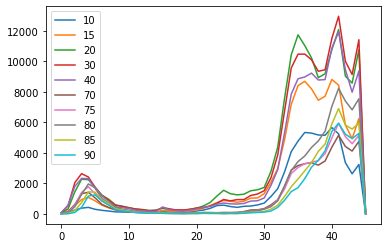

In [8]:

cases10y,cases5y = Cases.RKI_Altersverteilung()

for age in [10,15,20,30,40,70,75,80,85,90]:
    plt.plot(cases5y.sel(publication=datetime.datetime(2021,1,12),age=age),label=age)
plt.legend()


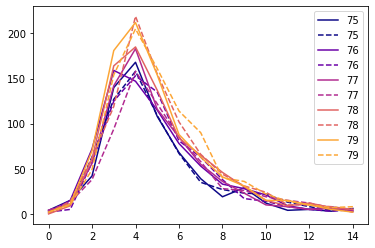

In [9]:
plasma = matplotlib.cm.plasma
for age in range(75,80):
    c = plasma((age-75)/5)
    plt.plot(cases.sum(["BL","category"]).sel(sex="male",age=age,week=range(10,25)),label=age,color=c)
    plt.plot(cases.sum(["BL","category"]).sel(sex="female",age=age,week=range(10,25)),"--",label=age,color=c)
plt.legend()

In [69]:
def Estimate_80plus_Cases(cases,age_dist,b1,b0=1.):
    """b2 = 2nd Bernstein-coefficient, b1 might be set to an offset for age80
        "sex","age",...,"BL","week"
    """
    bernstein_weights = Bernstein.Bernstein(2,21).dimshuffle(0,'x',1,'x','x')
    
    # Weighted connection over age = 70-79
    w10 = np.array([1/(x) for x in range(1,11)[::-1]],dtype="float64")
    f10 = np.sum(w10)
    w10 = w10.reshape((1,10,1,1))
    wc70 = tt.sum(cases[:,70:80,...] * w10,axis=1)
    wp70 = tt.sum(age_dist[:,70:80,...] * w10 ,axis=1)
    wf70 = wc70/wp70

    # Decompose weekly population 80+
    dpop = tt.cast(age_dist[:,80:,...],"float64").dimshuffle('x',0,1,2,3)*bernstein_weights * wf70.dimshuffle(0,'x',1,2)
    spop = tt.sum(dpop,axis=2)
    
    #residual after first bernstein contribution
    rpop = tt.maximum(cases[:,80,...]-b0*spop[0],1e-64)
    
    g = tt.minimum( (rpop - b1*spop[1]) / (spop[2]+1e-64), 1.)
    
    # Output-pop
    # currently too large b1 will bring about more cases than
    o80pop = b0*dpop[0] + b1*dpop[1] + (dpop[2].dimshuffle(1,0,2,3)*g).dimshuffle(1,0,2,3)


    return tt.concatenate([cases[:,:80,...],o80pop],axis=1),g,rpop
    
ct = cases.sum("category").sel(week=range(10,60),sex=["male","female"]).transpose("sex","age","BL","week")
ctt = tt.cast(ct,"float64")
print(ct.shape)
print(ct.coords)

wt = wpop.sel(week=range(10,60)).transpose("sex","age","BL","week")
print(wt.shape)

est,g_est,rest = Estimate_80plus_Cases(ctt,wt,2.3)

print(est.eval().shape)

ws = tt.sum(est,axis=(3)).eval()
print(np.sum(ws[:,81:],axis=1))
print(np.sum(ctt[:,80].eval(),axis=(2)))

g_est = g_est.eval()
#print(np.sum(g_est,axis=2))
print(g_est[:,0])

rest = rest.eval()
print(rest)

(2, 81, 16, 50)
Coordinates:
  * BL       (BL) int8 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * sex      (sex) <U7 'male' 'female'
  * age      (age) int8 0 1 2 3 4 5 6 7 8 9 10 ... 71 72 73 74 75 76 77 78 79 80
  * week     (week) int16 10 11 12 13 14 15 16 17 18 ... 52 53 54 55 56 57 58 59
(2, 101, 16, 50)
(2, 101, 16, 50)
[[  648.46356947   751.24474367  2377.99548337   191.44930307
   8977.45655484  3336.68060716  1809.72503175  6046.20279111
   8156.72728346   536.15225231  2225.10926032  1640.26362703
    383.65696648  5333.99141574  1243.50002697  1647.52029544]
 [  979.39806734  1196.00025452  3816.26204623   354.28723308
  14840.29246138  5170.26778137  3184.93022386  8922.35178806
  12719.85208275   968.43249597  3302.17514152  2589.77381444
    709.44779932  9410.45230806  2135.91039159  2785.34304909]]
[[  989.  1152.  3590.   287. 12012.  5011.  2765.  8324. 11480.   867.
   3157.  2496.   673.  8256.  1888.  2616.]
 [ 2027.  2374.  7732.   598. 24684. 10222.  6061. 16281. 

In [11]:
#def RKI_AgeGroups(data):
    

(2, 101, 16)


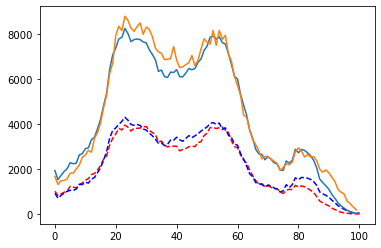

In [12]:
ecases = tt.sum(est[:,:,:,:47],axis=(3)).eval()
print(ecases.shape)

plt.plot(ecases[0,:,4],"r--")
plt.plot(ecases[1,:,4],"b--")
plt.plot(np.sum(ecases[:,:,4],axis=0))

hessen = np.array([348,273,307,311,325,378,379,416,453,525,546,591,572,702,754,844,986,1107,1304,1399,1657,1741,1700,1834,1796,1725,1694,1738,1772,1667,1733,1713,1647,1539,1504,1491,1432,1435,1440,1553,1426,1357,1365,1385,1404,1469,1375,1425,1529,1625,1592,1577,1703,1564,1703,1620,1657,1485,1417,1275,1191,1100,917,895,775,690,641,584,511,534,533,509,489,469,405,431,465,455,482,579,612,585,527,552,528,532,494,415,386,408,383,341,300,228,202,185,119,95,65,38])
plt.plot(4.8*hessen)

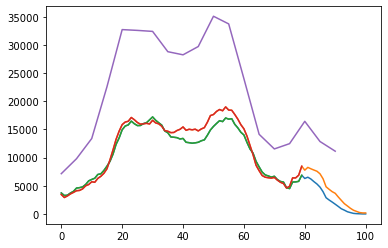

In [13]:
plt.plot(tt.sum(est,axis=(2,3,)).transpose((1,0)).eval())
plt.plot(cases.sel(sex=["male","female"],age=range(80)).sum(["category","BL","week"]).transpose("age","sex"))
plt.plot(age_cases5y.get_index("age"),age_cases5y.sel(publication=datetime.datetime(2021,1,19)).sum("week")/5.)

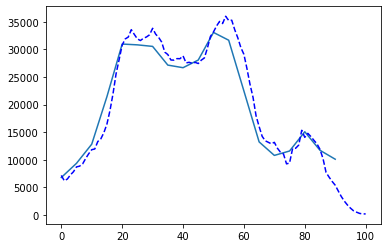

In [14]:
plt.plot(age_cases5y.get_index("age"),age_cases5y.sel(publication=datetime.datetime(2021,1,12)).sum("week") / 5. ) 
 
plt.plot(tt.sum(est,axis=(0,2,3,)).eval(),"b--")


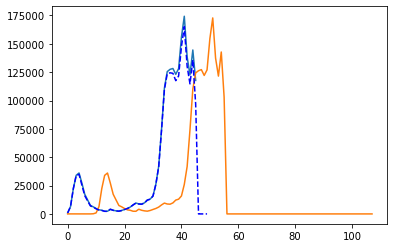

In [15]:
plt.plot(age_cases5y.sel(publication=datetime.datetime(2021,1,19)).sum(["age"]))
plt.plot(cases.sel(sex=["male","female"]).sum(["category","BL","age","sex"]))#.transpose("week","sex"))
plt.plot(tt.sum(est,axis=(0,1,2,)).eval(),"b--")

(2, 3, 16, 50) 144315.95958133572


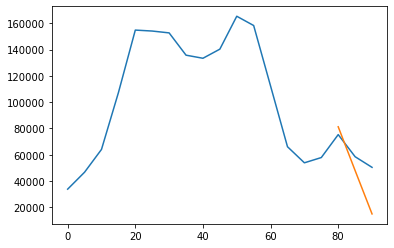

In [73]:
def SumAgeGroups80plus_5y_RKI(d):
    "sex","age",...,"BL","week"
    cs = tt.zeros_like(d)
#    cs = tt.set_subtensor(cs[:,0,...],tt.sum(d[:,80:85,...],axis=1))
#    cs = tt.set_subtensor(cs[:,1,...],tt.sum(d[:,85:90,...],axis=1))
#    cs = tt.set_subtensor(cs[:,2,...],tt.sum(d[:,90:,...],axis=1))
    
    cs = tt.set_subtensor(cs[:,0,...],tt.sum(d[:,80:86,...],axis=1))
    cs = tt.set_subtensor(cs[:,1,...],tt.sum(d[:,85:91,...],axis=1))
    cs = tt.set_subtensor(cs[:,2,...],tt.sum(d[:,91:,...],axis=1))
    
    return cs[:,:3,...]
    
ag80p = SumAgeGroups80plus_5y_RKI(est).eval()
print(ag80p.shape,np.sum(ag80p))

plt.plot(age_cases5y.get_index("age"),age_cases5y.sel(publication=datetime.datetime(2021,1,12)).sum("week") ) 
plt.plot(range(80,95,5),np.sum(ag80p,axis=(0,2,3,)))


In [74]:

wt_sw = wpop.sel(week=range(10,60)).transpose("sex","age","BL","week").sum("week",keepdims=True)
ctt_sw = tt.sum(ctt,axis=3,keepdims=True)
print(wt_sw.shape)
print(ctt_sw.eval().shape)

est_sw,g_est_sw,rest_sw = Estimate_80plus_Cases(ctt_sw,wt_sw,2.3)

ag80p_sw = SumAgeGroups80plus_5y_RKI(est_sw).eval()

print(est_sw.eval().shape)

(2, 101, 16, 1)
(2, 81, 16, 1)
(2, 101, 16, 1)


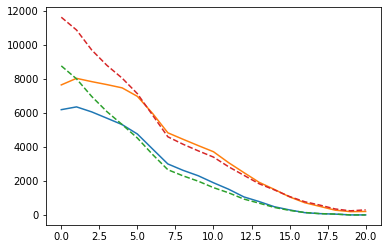

In [75]:
esw = est_sw.eval()

plt.plot(esw.sum(axis=(2,3)).transpose(1,0)[80:])
plt.plot(wt_sw.sum(axis=(2,3)).transpose("age","sex")[80:]/2000.,"--")



ValueError: x and y must have same first dimension, but have shapes (3,) and (2, 3)

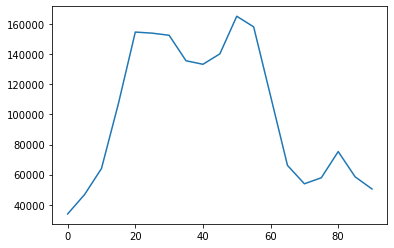

In [77]:
#
#plt.plot(range(0,15,5),ag80p_sw.sum(axis=(2,3)).transpose(1,0)/5)

plt.plot(age_cases5y.get_index("age"),age_cases5y.sel(publication=datetime.datetime(2021,1,12)).sum("week") ) 
plt.plot(range(80,95,5),np.sum(ag80p_sw,axis=(2,3,)))